- `TODO: adjust ...` 代表要改的

## Download Library

In [9684]:
# !pip install ipykernel
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !pip install opencv-python

## import Library

In [9685]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## MNIST

## Data Structure

```text
.
├── dataset
│   └── mnist
│       └── train
│           ├── data
│           │   ├── 0.jpg
│           │   ├── 1.jpg
│           │   ├── ...
│           │   └── 59999.jpg
│           └── label.txt
└── mnist.ipynb  (訓練 MNIST)
```


### Implement dataset class

In [9686]:
label_dict = {
    'A': 0, 'BA': 1, 'CHI': 2, 'DA': 3, 'E': 4, 'FU': 5, 'HA': 6, 'HE': 7, 'HI': 8, 'HO': 9, 'I': 10, 'JI': 11,
    'KA': 12, 'KE': 13, 'KI': 14, 'KO': 15, 'KU': 16, 'MA': 17, 'ME': 18, 'MI': 19, 'MO': 20, 'MU': 21, 'N': 22,
    'NA': 23, 'NE': 24, 'NI': 25, 'NO': 26, 'NU': 27, 'O': 28, 'PI': 29, 'RA': 30, 'RE': 31, 'RI': 32, 'RO': 33,
    'RU': 34, 'SA': 35, 'SE': 36, 'SHI': 37, 'SO': 38, 'SU': 39, 'TA': 40, 'TE': 41, 'TO': 42, 'TSU': 43, 'U':
    44, 'WA': 45, 'WO': 46, 'YA': 47, 'YO': 48, 'YU': 49
}

label_dict_inv = {v: k for k, v in label_dict.items()}
label_dict_inv


{0: 'A',
 1: 'BA',
 2: 'CHI',
 3: 'DA',
 4: 'E',
 5: 'FU',
 6: 'HA',
 7: 'HE',
 8: 'HI',
 9: 'HO',
 10: 'I',
 11: 'JI',
 12: 'KA',
 13: 'KE',
 14: 'KI',
 15: 'KO',
 16: 'KU',
 17: 'MA',
 18: 'ME',
 19: 'MI',
 20: 'MO',
 21: 'MU',
 22: 'N',
 23: 'NA',
 24: 'NE',
 25: 'NI',
 26: 'NO',
 27: 'NU',
 28: 'O',
 29: 'PI',
 30: 'RA',
 31: 'RE',
 32: 'RI',
 33: 'RO',
 34: 'RU',
 35: 'SA',
 36: 'SE',
 37: 'SHI',
 38: 'SO',
 39: 'SU',
 40: 'TA',
 41: 'TE',
 42: 'TO',
 43: 'TSU',
 44: 'U',
 45: 'WA',
 46: 'WO',
 47: 'YA',
 48: 'YO',
 49: 'YU'}

### Implement model class

In [9687]:
class MyDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = Path(path)
        self.transform = transform
        self.images, self.labels = self.readData()

    def readData(self):
        images = []
        labels = []

        for path in self.path.glob('**/*'):
            if path.suffix in ['.jpg']:
                images.append(Image.open(path).copy())
                img_name = path.stem
                if img_name[4:7].isalpha() == True:
                    label_name = img_name[4:7]
                elif img_name[4:6].isalpha() == True:
                    label_name = img_name[4:6]
                else:
                    label_name = img_name[4]
              
            
                labels.append(label_dict[label_name])

        ## 使用for 迴圈 從self.path 讀取所有的圖片(*.jpg)檔案路徑 #TODO
            # Image.open() 讀取圖片 #TODO
            
            # 將圖片加入 images 列表 #TODO
            
            # 假設檔名格式為 'kanaYA1.jpg' 提取YA 作為標籤 #TODO
            
            # 將標籤轉換為數字並加入 labels 列表 #TODO
            
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img, label = self.images[index], self.labels[index]

        if self.transform:
            img = self.transform(img)
        return img, label


### Define Parameters

In [9688]:
dataset_path = 'C:/Users/User/Documents/hiragana-dataset-master/hiragana_images'  # TODO: adjust path
batch_size = 16
img_size=(28, 28) 
## dataloader #TODO 資料前處理
transform = transforms.Compose([ 
    transforms.Resize(img_size),
    transforms.ToTensor(),   # [0, 1]
    # transforms.Normalize((0.5), (0.5))  # [-1, 1]
    ])

dataset = MyDataset(path=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
## 分成訓練集和測試集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Found 32 images with labels 0~31


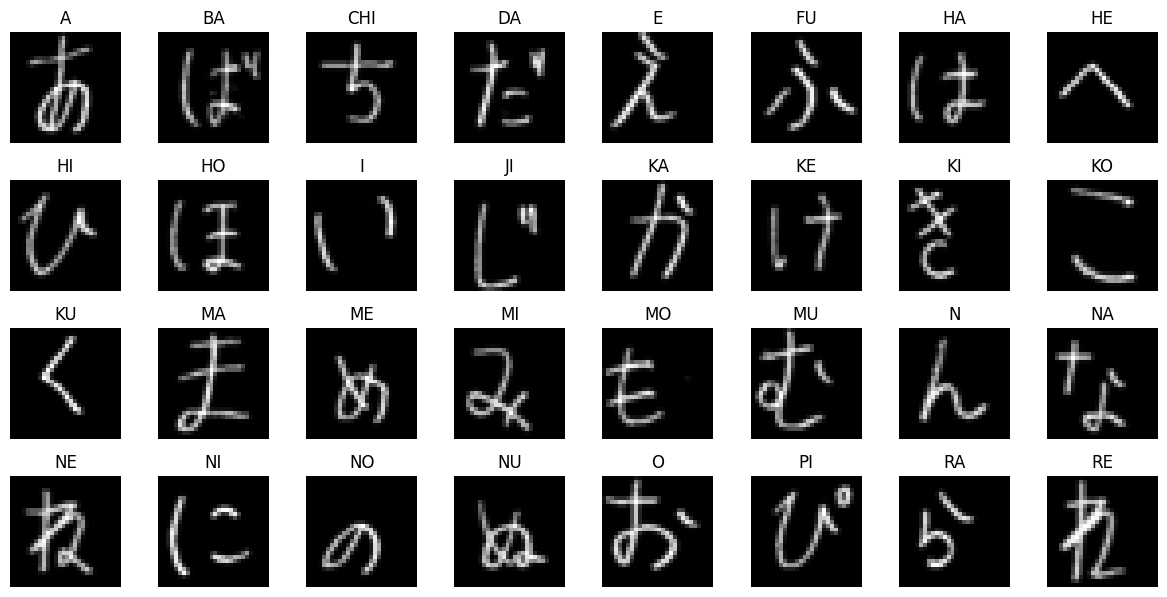

In [9689]:
def show_images(images, labels):
    plt.figure(figsize=(12, 12))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(8, 8, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(label_dict_inv[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_one_per_label(dataset, label_min=0, label_max=32):
    seen = set()
    imgs, labels = [], []
    for img, label in dataset:
        if label_min <= label <= label_max and label not in seen:
            imgs.append(img)
            labels.append(label)
            seen.add(label)
        if len(seen) == label_max - label_min + 1:
            break
    print(f"Found {len(imgs)} images with labels {label_min}~{label_max}")
    show_images(imgs, labels)

# 使用
show_one_per_label(dataset, 0, 31)

In [9690]:
class Net(nn.Module):
    def __init__(self,in_channels=1, num_classes=50):
        super(Net, self).__init__()
        ## 定義卷積層、池化層、全連接層等 #TODO

        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=5, stride=1, padding=0) # out_shape=(16,24,24)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # out_shape=(16,12,12)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) # out_shape=(32,8,8)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # out_shape=(32,4,4)

        self.fc1 = nn.Linear(in_features=32 * 4 * 4, out_features=num_classes)  # in_shape=(32*4*4)  # TODO: adjust in_features

    def forward(self, x):
        ## 定義前向傳播過程 #TODO
        x = self.cnn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x


In [9691]:
## 參數自己定義 #TODO
epochs = 12
learning_rate = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Build
(1)model, (2)loss-function, (3)optimizer, (4)dataloader

In [9692]:
model = Net()
model.to(device)
## TODO loss function 
criterion = nn.CrossEntropyLoss()
## TODO optimizer
optimizer =torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9693]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, (1, img_size[0], img_size[1]), device=str(device))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
              ReLU-2           [-1, 16, 24, 24]               0
         MaxPool2d-3           [-1, 16, 12, 12]               0
            Conv2d-4             [-1, 32, 8, 8]          12,832
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Linear-7                   [-1, 50]          25,650
Total params: 38,898
Trainable params: 38,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.15
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


### Training

In [9694]:
def accuracy(pred: torch.Tensor, label: torch.Tensor):
    _, pred_label = pred.max(1)
    num_correct = (pred_label == label).sum().item()
    acc = num_correct / label.shape[0]
    return acc
metric = {'loss': [], 'acc': [],'test_loss':[], 'test_acc': []}
for i_epoch in tqdm(range(epochs)):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    model.train(mode=True)
    for i_batch, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        pred = model.forward(image)  # inference
        loss = criterion(pred, label)  # calculate loss

        ## TODO inference 

        ## TODO calculate loss
        
        optimizer.zero_grad()  # reset gradient to zero

        loss.backward()  # calculate gradient
        optimizer.step()  # optimize weight (using gradient)

        ## TODO calculate gradient
        
        ## TODO optimize weight (using gradient)

        train_loss += [loss.item()]
        train_acc += [accuracy(pred, label)]
    model.eval()
    with torch.no_grad():
        for i_batch, (image, label) in enumerate(test_loader):    
            image = image.to(device)
            label = label.to(device)

            pred = model.forward(image)  # inference
            loss = criterion(pred, label)  # calculate loss

            test_loss += [loss.item()]
            test_acc += [accuracy(pred, label)]
    metric['loss'] += [sum(train_loss)/ len(train_loader)]
    metric['acc'] += [sum(train_acc)/ len(train_loader)]
    metric['test_loss'] += [sum(test_loss)/ len(test_loader)]
    metric['test_acc'] += [sum(test_acc)/ len(test_loader)]
    #print(f'Epoch[{i_epoch+1}/{epochs}] loss: {metric["loss"][-1]}, acc: {metric["acc"][-1]} testloss: {metric["test_loss"][-1]}, testacc: {metric["test_acc"][-1]}')

100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


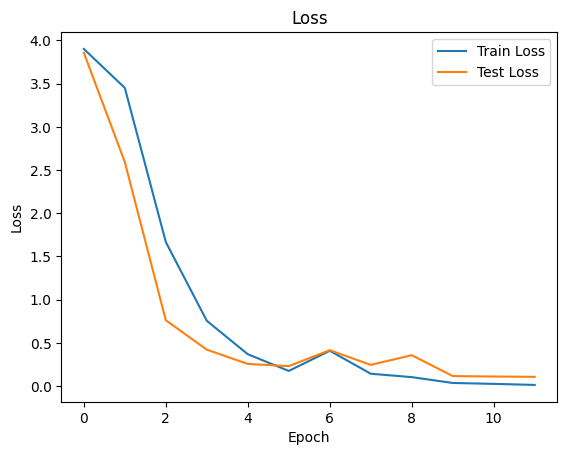

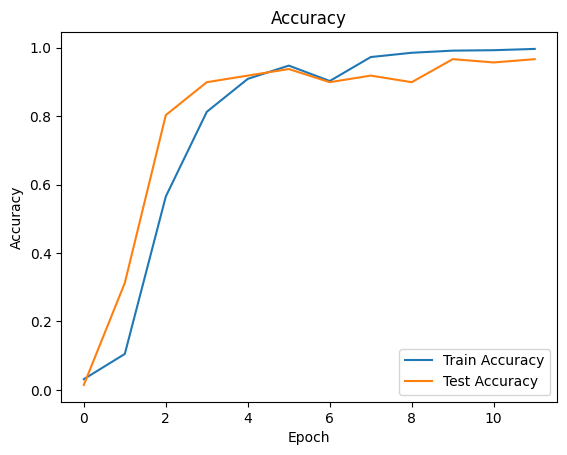

loss: 0.014495981899090111, acc: 0.99625 testloss: 0.10814071031144032, testacc: 0.9663461538461539


In [9695]:
plt.plot(range(len(metric["loss"])), metric["loss"])
plt.plot(range(len(metric["test_loss"])), metric["test_loss"])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()
plt.plot(range(len(metric["acc"])), metric["acc"])
plt.plot(range(len(metric["test_acc"])), metric["test_acc"])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()
print(f'loss: {metric["loss"][-1]}, acc: {metric["acc"][-1]} testloss: {metric["test_loss"][-1]}, testacc: {metric["test_acc"][-1]}')

### Save Model

In [9696]:
model_scripted = torch.jit.script(model.cpu())
model_scripted.save('model_scripted_32.pt')

### Load Model